In [1]:
import OptionsContract
import Pricer

option_param = OptionsContract.ContractParam(S0=100, K=100, T=1,
                                             exercise="american",
                                             payoff="call")
option_pricer = Pricer.Pricer(option_param, r=0.1, sigma=0.2, mu=0.1)


In [2]:
option_pricer.black_scholes_pde((5000, 4000))

np.float64(13.26941766296203)

In [3]:
import pandas as pd

df = pd.read_csv('../data/combined_df.csv')

In [4]:
df.head()

,ticker,quote_date,underlying_last,expire_date,dte,c_delta,c_gamma,c_vega,c_theta,c_rho,...,p_theta,p_rho,p_iv,p_volume,strike_distance,strike_distance_pct,c_actual_price,p_actual_price,c_abs_error,p_abs_error
0,aapl,2019-01-02,157.92,2019-01-04,2.0,0.90886,0.00019,0.01709,-0.1004,0.00074,...,-0.00509,-0.00041,1.62555,0.0,57.9,0.367,57.90,0.010,0.70,0.000
1,aapl,2019-01-02,157.92,2019-01-04,2.0,1.00000,0.00000,0.00000,0.0000,0.00000,...,-0.00518,-0.00010,1.46190,200.0,52.9,0.335,52.73,0.005,52.73,0.005
2,aapl,2019-01-02,157.92,2019-01-04,2.0,1.00000,0.00000,0.00000,0.0000,0.00000,...,-0.00425,-0.00009,1.30549,706.0,47.9,0.303,47.62,0.005,47.62,0.035
3,aapl,2019-01-02,157.92,2019-01-04,2.0,1.00000,0.00000,0.00000,0.0000,0.00000,...,-0.00434,-0.00005,1.15513,0.0,42.9,0.272,42.67,0.005,6.08,0.005
4,aapl,2019-01-02,157.92,2019-01-04,2.0,1.00000,0.00000,0.00000,0.0000,0.00000,...,-0.00429,-0.00020,1.01062,0.0,37.9,0.240,37.66,0.005,2.21,0.005


In [5]:
df.columns

Index(['ticker', 'quote_date', 'underlying_last', 'expire_date', 'dte',
       'c_delta', 'c_gamma', 'c_vega', 'c_theta', 'c_rho', 'c_iv', 'c_volume',
       'c_last', 'c_size', 'c_bid', 'c_ask', 'strike', 'p_bid', 'p_ask',
       'p_size', 'p_last', 'p_delta', 'p_gamma', 'p_vega', 'p_theta', 'p_rho',
       'p_iv', 'p_volume', 'strike_distance', 'strike_distance_pct',
       'c_actual_price', 'p_actual_price', 'c_abs_error', 'p_abs_error'],
      dtype='object')

In [6]:
df['quote_month'] = pd.to_datetime(df['quote_date']).dt.month
df['quote_year'] = pd.to_datetime(df['quote_date']).dt.year

In [7]:
df.head()

,ticker,quote_date,underlying_last,expire_date,dte,c_delta,c_gamma,c_vega,c_theta,c_rho,...,p_iv,p_volume,strike_distance,strike_distance_pct,c_actual_price,p_actual_price,c_abs_error,p_abs_error,quote_month,quote_year
0,aapl,2019-01-02,157.92,2019-01-04,2.0,0.90886,0.00019,0.01709,-0.1004,0.00074,...,1.62555,0.0,57.9,0.367,57.90,0.010,0.70,0.000,1,2019
1,aapl,2019-01-02,157.92,2019-01-04,2.0,1.00000,0.00000,0.00000,0.0000,0.00000,...,1.46190,200.0,52.9,0.335,52.73,0.005,52.73,0.005,1,2019
2,aapl,2019-01-02,157.92,2019-01-04,2.0,1.00000,0.00000,0.00000,0.0000,0.00000,...,1.30549,706.0,47.9,0.303,47.62,0.005,47.62,0.035,1,2019
3,aapl,2019-01-02,157.92,2019-01-04,2.0,1.00000,0.00000,0.00000,0.0000,0.00000,...,1.15513,0.0,42.9,0.272,42.67,0.005,6.08,0.005,1,2019
4,aapl,2019-01-02,157.92,2019-01-04,2.0,1.00000,0.00000,0.00000,0.0000,0.00000,...,1.01062,0.0,37.9,0.240,37.66,0.005,2.21,0.005,1,2019


In [10]:
cur_df = df[df['quote_date'] == '2021-05-14']


In [11]:
import time
import OptionsContract
import Pricer

start = time.perf_counter()

calculated_prices = []

for index, row in cur_df.iterrows():
    # Set K as the strike price
    K = row['strike']
    # Set T as the time to expiration in years.
    T = row['dte'] / 365

    option_param = OptionsContract.ContractParam(S0=row['underlying_last'],
                                          K=row['strike'],
                                          T=row['dte'] / 365,
                                          dividend_yield=0,
                                          payoff='call',
                                          exercise='american')
    if option_param.payoff == 'call':
        # Use IV for Call options
        sigma = row['c_iv']
    else:
        sigma = row['p_iv']
    pricer = Pricer.Pricer(option_param, r=0.1, sigma=sigma, mu=0.1)

    price = pricer.binomial_tree(N=100)

    calculated_prices.append(round(price, 2))

end = time.perf_counter()

print(f"Execution time: {end - start:.6f} seconds")



/Users/tacobell/Documents/Workspace/NEU/2025_SPRING/OptionPricer/src/optionpricer/Pricer.py:125: RuntimeWarning: invalid value encountered in scalar divide
  p = (a - d) / (u - d)  # risk neutral up probability
/Users/tacobell/Documents/Workspace/NEU/2025_SPRING/OptionPricer/src/optionpricer/Pricer.py:125: RuntimeWarning: divide by zero encountered in scalar divide
  p = (a - d) / (u - d)  # risk neutral up probability
/Users/tacobell/Documents/Workspace/NEU/2025_SPRING/OptionPricer/src/optionpricer/Pricer.py:135: RuntimeWarning: invalid value encountered in add
  self.price_vector[:-1] = np.exp(-self.r * dT) * (p * self.price_vector[


Execution time: 5.092014 seconds


In [13]:
cur_df['projected_price'] = calculated_prices

/var/folders/s_/jfx9xxpj0l965x3w3pf_wlgc0000gn/T/ipykernel_1906/2803670283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['projected_price'] = calculated_prices


In [20]:
c_mean_abs_error = cur_df['c_abs_error'].mean()
c_mean_abs_error

np.float64(30.05607182106148)

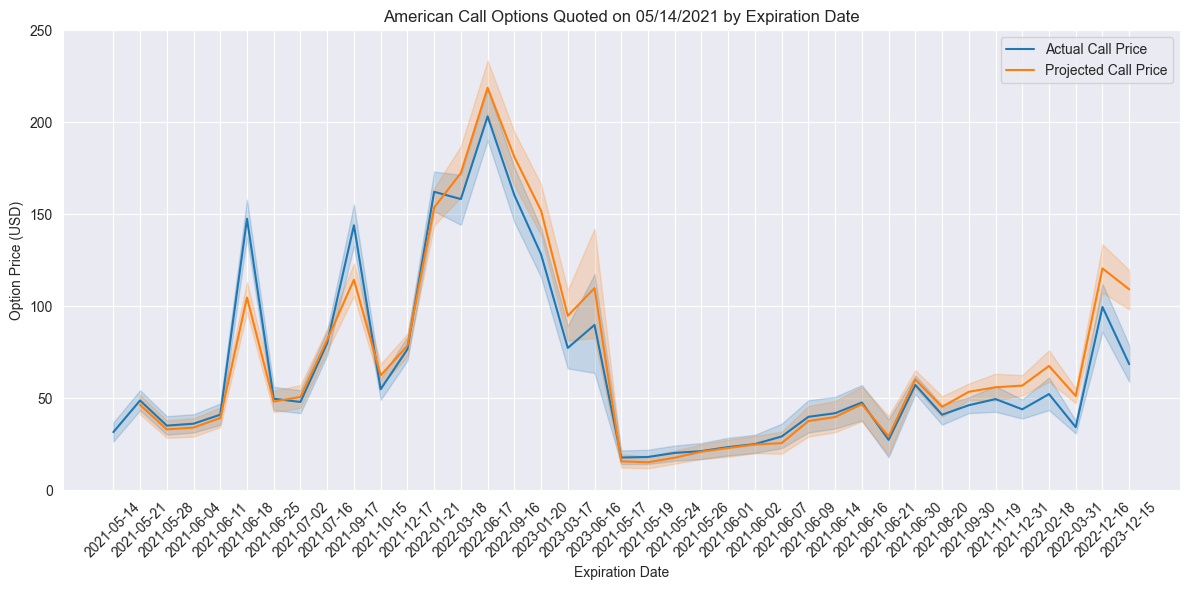

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.lineplot(data=cur_df, x='expire_date', y='c_actual_price', label='Actual Call Price')
sns.lineplot(data=cur_df, x='expire_date', y='projected_price', label='Projected Call Price')
plt.title('American Call Options Quoted on 05/14/2021 by '
          'Expiration Date')
plt.ylim(0, 250)
plt.xlabel('Expiration Date')
plt.xticks(rotation=45)
plt.ylabel('Option Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()